In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [27]:
df = pd.read_csv('training_data.csv')

# Descriptive statistics

In [28]:
desc_stats = df.describe()
print("Descriptive Statistics:\n", desc_stats)

Descriptive Statistics:
             zipcode  AveragePrice          Year         Month   ArrestCount  \
count  21700.000000  2.170000e+04  21700.000000  21700.000000  21700.000000   
mean   10835.998940  6.705753e+05   2015.276221      6.503410    157.206083   
std      564.848815  4.760545e+05      3.670456      3.449295    148.179991   
min    10001.000000  9.481300e+04   2010.000000      1.000000      1.000000   
25%    10305.000000  3.888732e+05   2012.000000      4.000000     49.000000   
50%    11205.000000  5.277210e+05   2015.000000      7.000000    115.000000   
75%    11362.000000  7.572975e+05   2018.000000      9.000000    215.000000   
max    11694.000000  4.557873e+06   2023.000000     12.000000   1039.000000   

       NoiseComplaints         count  distance_to_facility  cultural_facility  \
count     21700.000000  21700.000000          21700.000000       21700.000000   
mean        178.833180     69.434562              1.166728           2.833917   
std         179.8459

In [29]:
# Mean sales and average household income
mean_values = df.groupby('zipcode').agg({'AveragePrice': 'mean', 'average_household_income': 'mean'})
mean_values.rename(columns={'AveragePrice': 'MeanSales', 'average_household_income': 'MeanHouseholdIncome'}, inplace=True)
print("Mean Sales and Average Household Income:\n", mean_values)

Mean Sales and Average Household Income:
             MeanSales  MeanHouseholdIncome
zipcode                                   
10001    2.239767e+06        164953.202440
10002    8.015409e+05         54121.211686
10003    1.392722e+06        248253.131343
10004    1.375893e+06        349748.050167
10005    1.334891e+06        620393.071221
...               ...                  ...
11435    4.815144e+05         41380.049296
11436    3.473061e+05         40131.369011
11691    4.006407e+05         40765.211958
11692    3.197547e+05         39599.859520
11694    6.188641e+05         90982.962249

[166 rows x 2 columns]


Cluster Centers:
 [[-0.31253851  0.23312262]
 [ 1.46876405 -0.43016352]
 [-0.39292963  1.53511327]
 [-0.33556805 -0.81204767]
 [ 4.37210874 -0.89020011]]


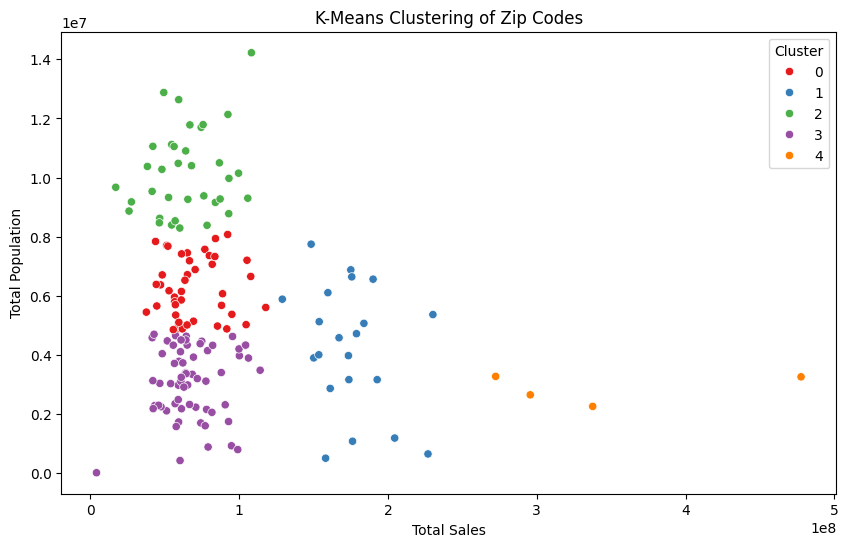

In [30]:
# K-means clustering for AveragePrice and population
kpi = df.groupby('zipcode').agg({'AveragePrice': 'sum', 'population': 'sum'}).reset_index()
kpi.rename(columns={'AveragePrice': 'TotalSales', 'population': 'TotalPopulation'}, inplace=True)

# Standardize data
scaler = StandardScaler()
kpi_scaled = scaler.fit_transform(kpi[['TotalSales', 'TotalPopulation']])

# Perform k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(kpi_scaled)
kpi['Cluster'] = kmeans.labels_

# Cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

# Add clusters to the original data
df = df.merge(kpi[['zipcode', 'Cluster']], on='zipcode', how='left')

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSales', y='TotalPopulation', hue='Cluster', data=kpi, palette='Set1')
plt.title('K-Means Clustering of Zip Codes')
plt.xlabel('Total Sales')
plt.ylabel('Total Population')
plt.show()

# 1. Time Series Visualization

C:\Users\simon\AppData\Local\Temp\ipykernel_28804\2584833663.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


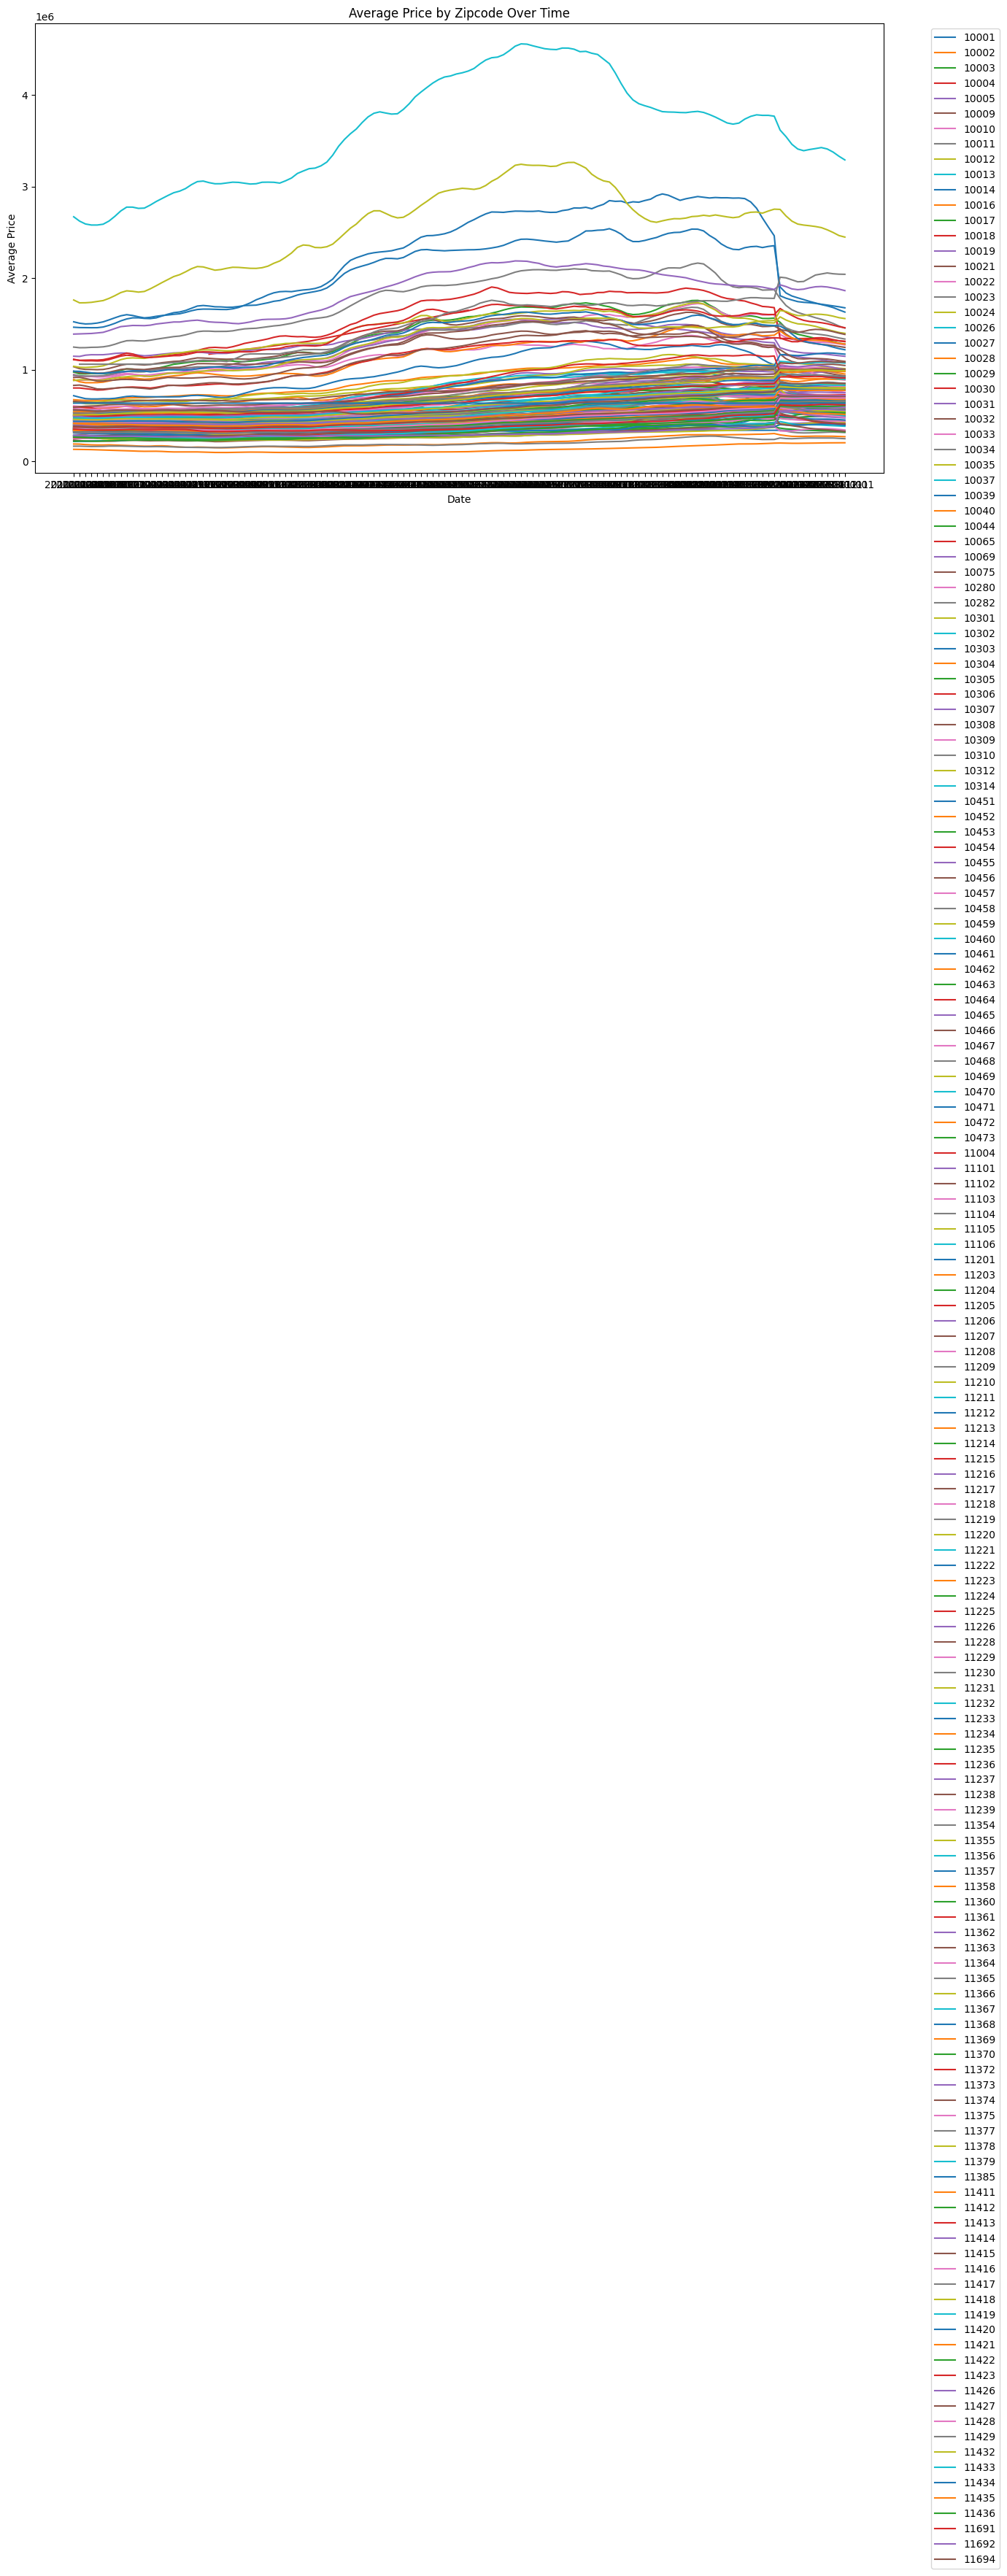

In [31]:
plt.figure(figsize=(15,8))
for zipcode in df['zipcode'].unique():
    zipcode_data = df[df['zipcode'] == zipcode]
    plt.plot(zipcode_data['YearMonth'], zipcode_data['AveragePrice'], label=zipcode)
plt.title('Average Price by Zipcode Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Distribution Analysis

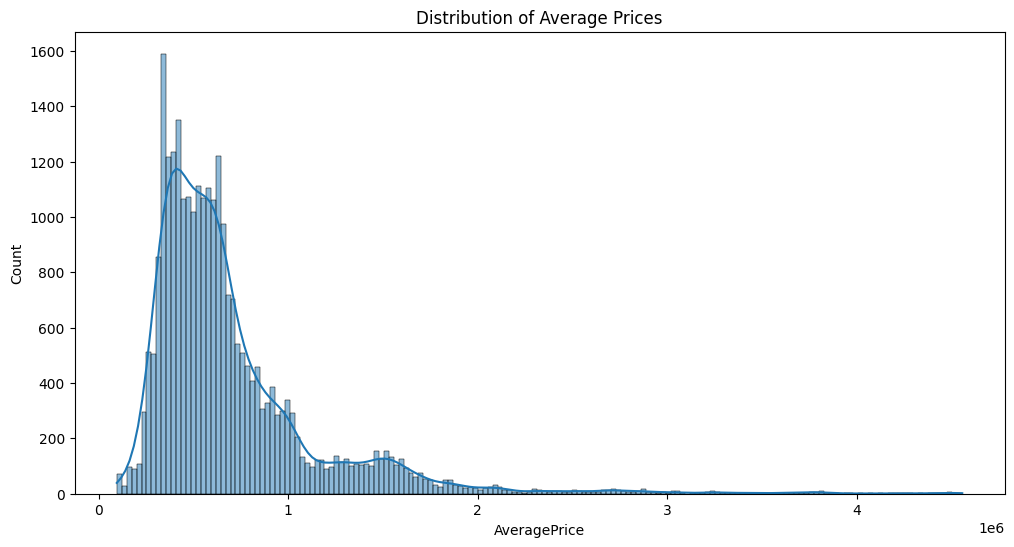

In [5]:
plt.figure(figsize=(12,6))
sns.histplot(df['AveragePrice'], kde=True)
plt.title('Distribution of Average Prices')
plt.show()

# 3. Correlation Analysis

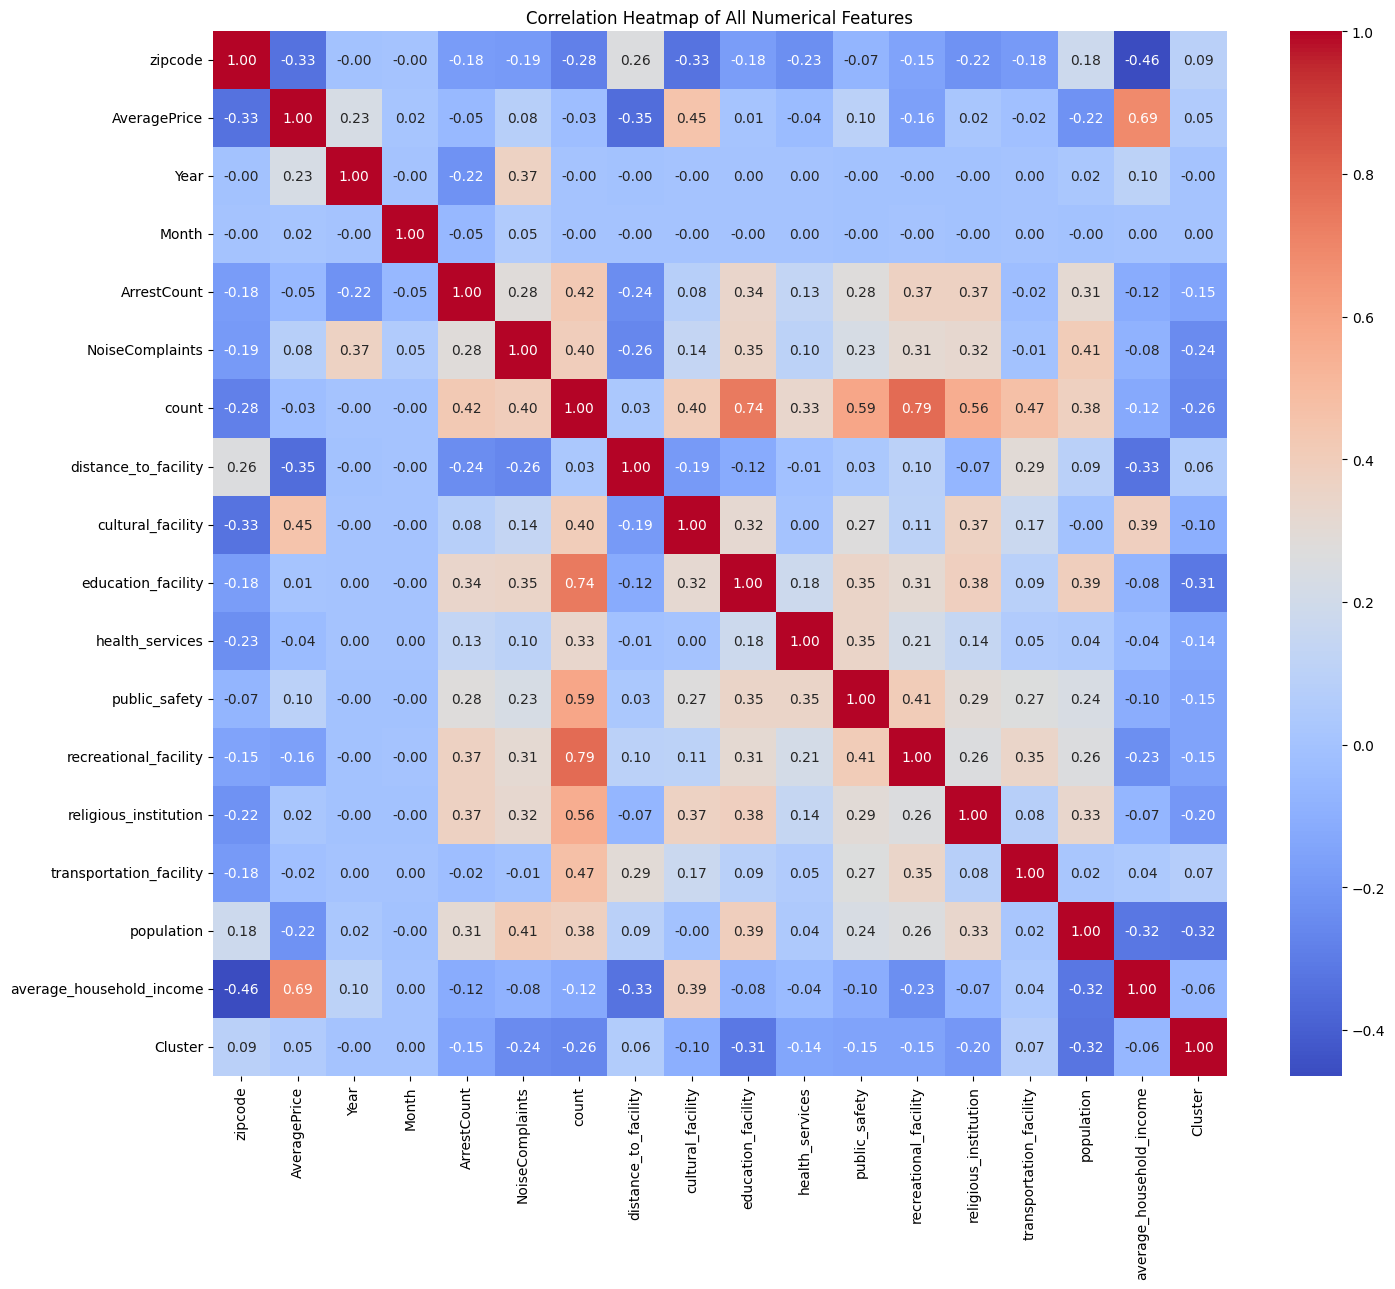

In [32]:
numerical_columns = df.select_dtypes(include=[np.number]).columns

correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(15,13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of All Numerical Features')
plt.tight_layout()
plt.show()

# 4. Seasonality and Trend Analysis

<Figure size 1500x1200 with 0 Axes>

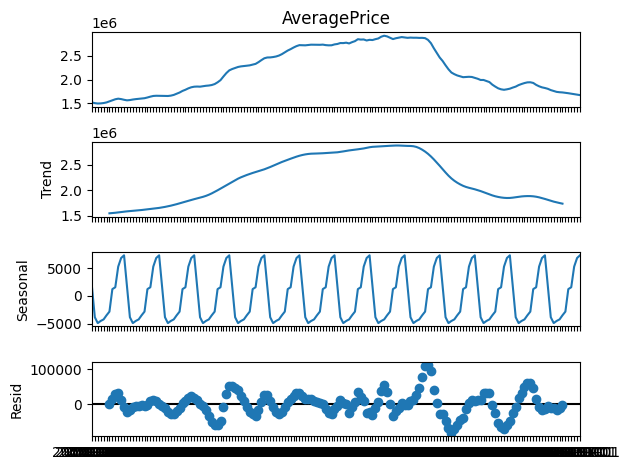

In [7]:
sample_zipcode = df['zipcode'].mode().iloc[0]
sample_data = df[df['zipcode'] == sample_zipcode].set_index('YearMonth')['AveragePrice']

decomposition = seasonal_decompose(sample_data, model='additive', period=12)
plt.figure(figsize=(15,12))
decomposition.plot()
plt.tight_layout()
plt.show()


# 5. Borough and Zipcode Comparisons

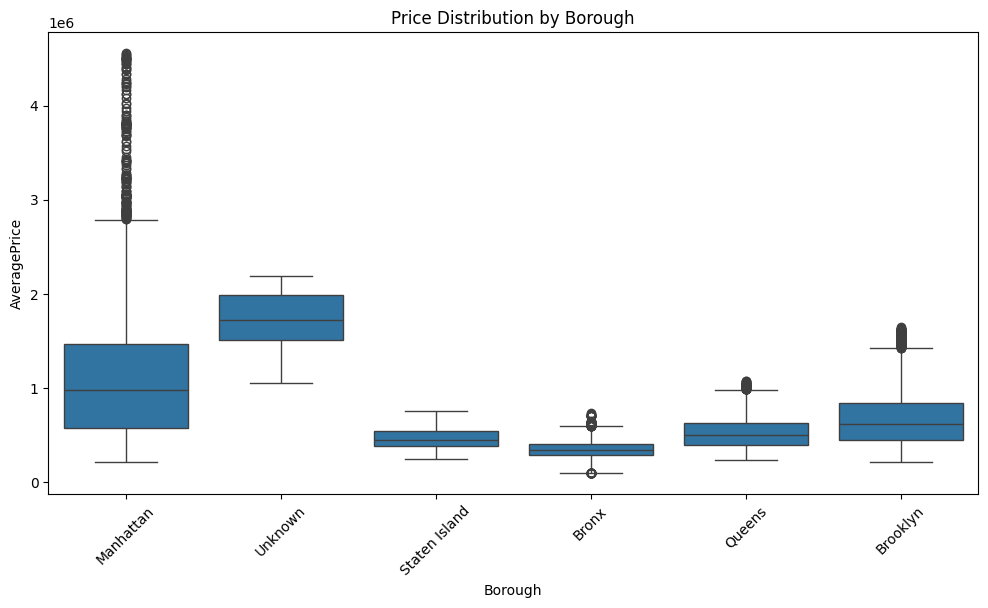

In [33]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Borough', y='AveragePrice', data=df)
plt.title('Price Distribution by Borough')
plt.xticks(rotation=45)
plt.show()

# Top 5 and bottom 5 zipcodes by average price

In [34]:
top_5 = df.groupby('zipcode')['AveragePrice'].mean().nlargest(5)
bottom_5 = df.groupby('zipcode')['AveragePrice'].mean().nsmallest(5)

print("Top 5 zipcodes by average price:")
print(top_5)
print("\nBottom 5 zipcodes by average price:")
print(bottom_5)


Top 5 zipcodes by average price:
zipcode
10013    3.618358e+06
10012    2.557605e+06
10001    2.239767e+06
10014    2.063526e+06
10069    1.859861e+06
Name: AveragePrice, dtype: float64

Bottom 5 zipcodes by average price:
zipcode
10462    129263.393939
10468    196909.446970
10452    209047.522727
10459    284951.106061
10456    290389.393939
Name: AveragePrice, dtype: float64


# Price growth rate

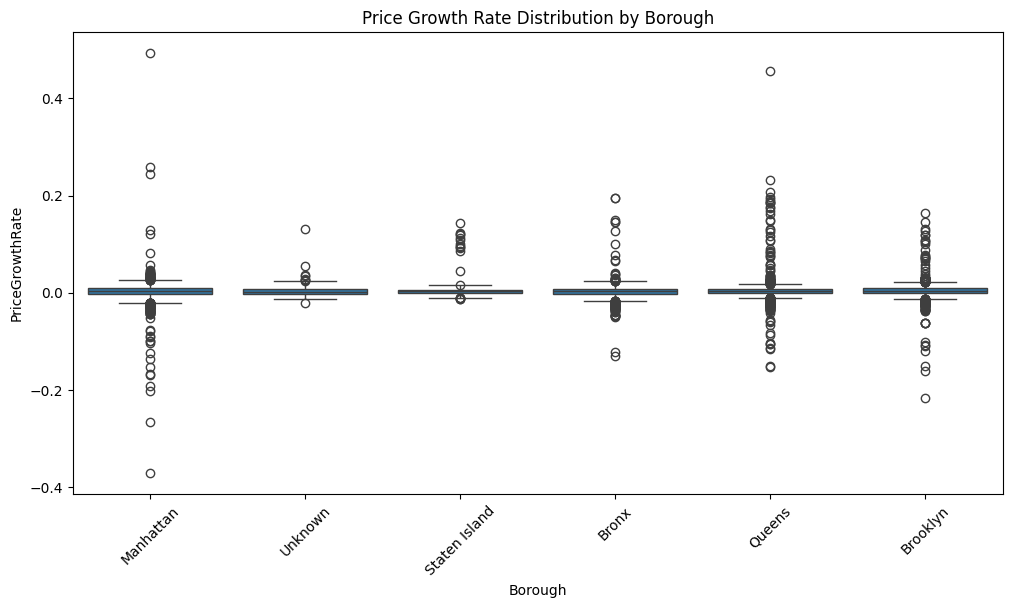

In [35]:
df['PriceGrowthRate'] = df.groupby('zipcode')['AveragePrice'].pct_change()
plt.figure(figsize=(12,6))
sns.boxplot(x='Borough', y='PriceGrowthRate', data=df)
plt.title('Price Growth Rate Distribution by Borough')
plt.xticks(rotation=45)
plt.show()

# Relationship between price and other factors

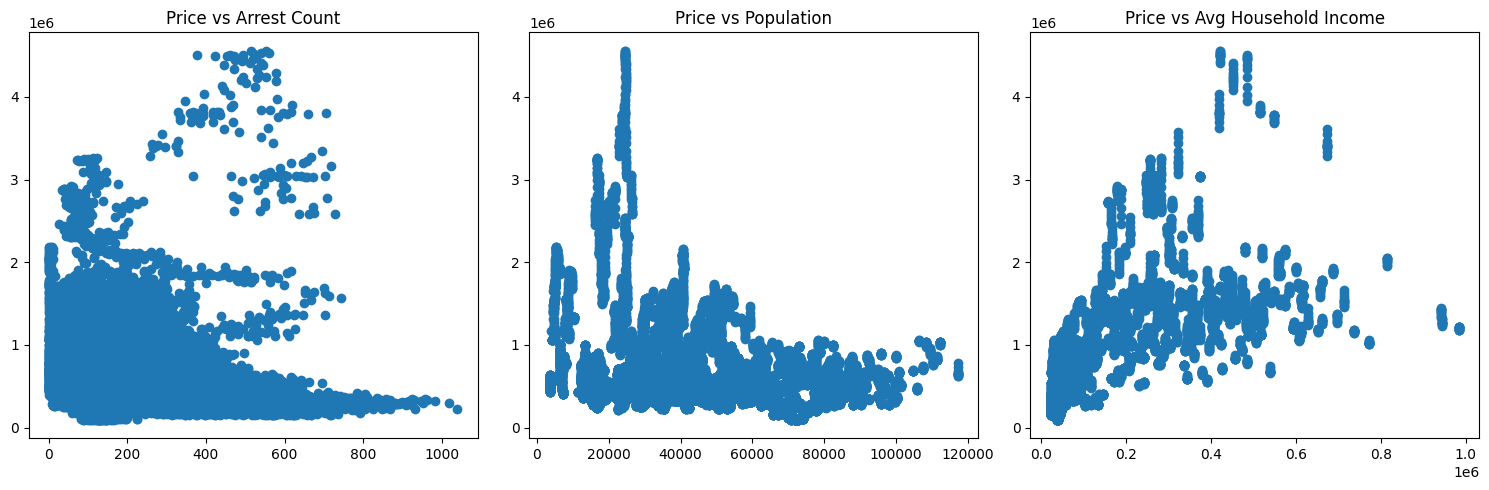

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(df['ArrestCount'], df['AveragePrice'])
plt.title('Price vs Arrest Count')
plt.subplot(132)
plt.scatter(df['population'], df['AveragePrice'])
plt.title('Price vs Population')
plt.subplot(133)
plt.scatter(df['average_household_income'], df['AveragePrice'])
plt.title('Price vs Avg Household Income')
plt.tight_layout()
plt.show()

# 2. Feature Importance Analysis

In [37]:
X = df[numerical_columns].drop('AveragePrice', axis=1)
y = df['AveragePrice']

In [38]:
categorical_columns = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
    X[col] = df[col]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [41]:
#  feature importances
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

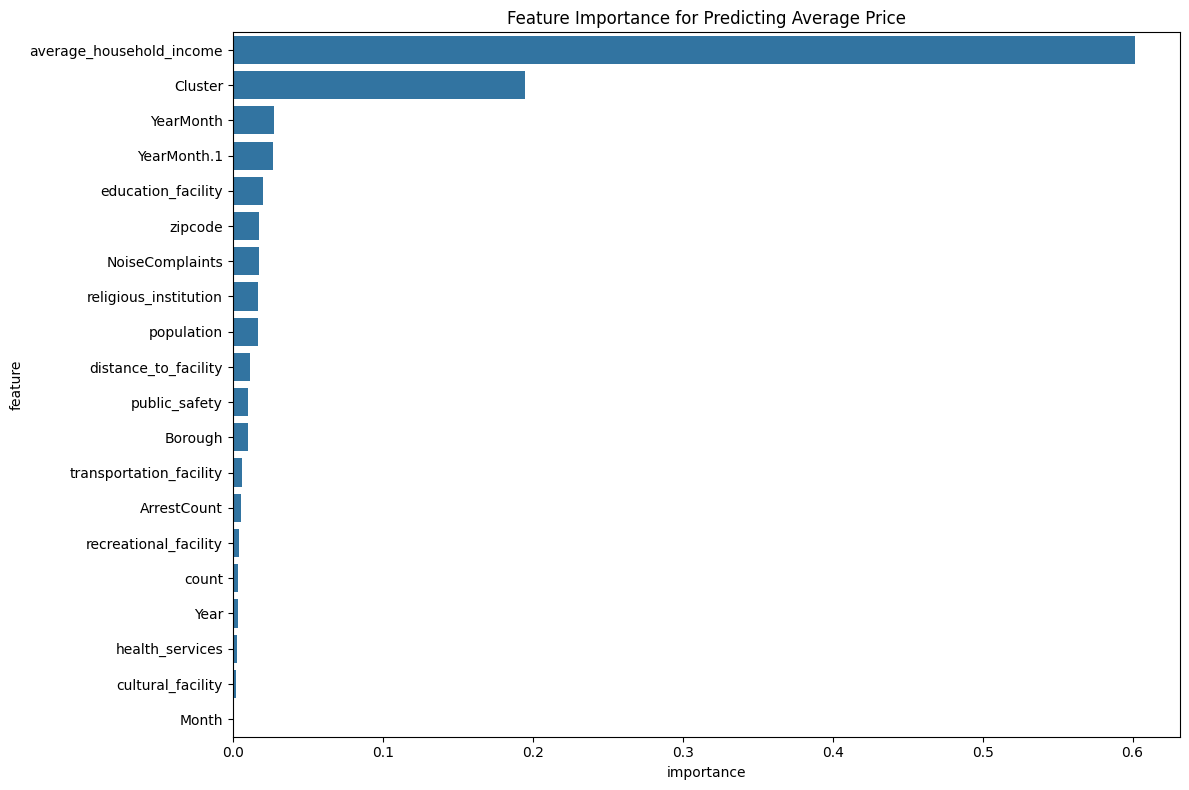

In [42]:
#  feature importances
plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Average Price')
plt.tight_layout()
plt.show()

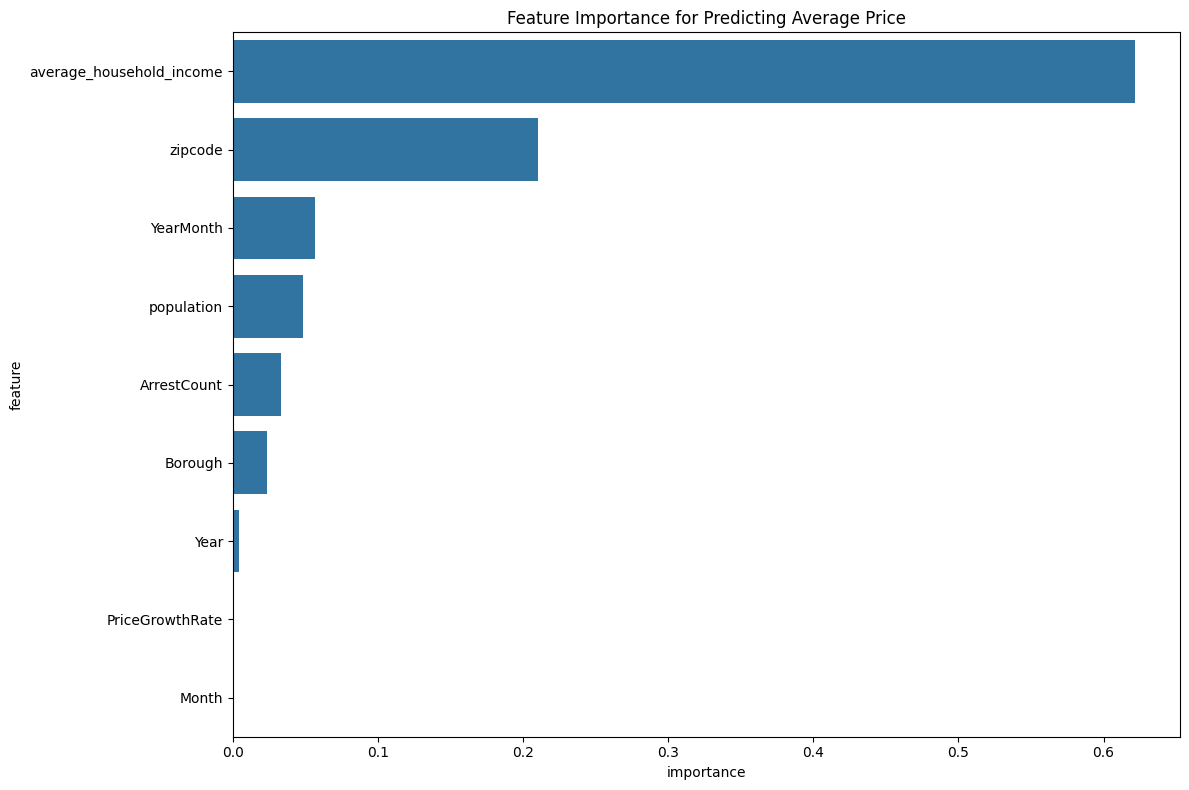

In [20]:
# feature importances
plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Average Price')
plt.tight_layout()
plt.show()